In [128]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Connect model with the workbench

In [121]:
from ema_workbench import (
    Model,
    RealParameter,
    ScalarOutcome,
    Constant,
    ema_logging,
    MultiprocessingEvaluator,
    CategoricalParameter,
    Scenario,
    save_results
)

from lake_model_dps import lake_problem

# allways enable loging when working with the workbench
ema_logging.log_to_stderr(ema_logging.INFO)

# instantiate the model
lake_model = Model("lakeproblem", function=lake_problem)

# specify uncertainties
lake_model.uncertainties = [
    RealParameter("b", 0.1, 0.45),
    RealParameter("q", 2.0, 4.5),
    RealParameter("mean", 0.01, 0.05),
    RealParameter("stdev", 0.001, 0.005),
    RealParameter("delta", 0.93, 0.99),
]

# set levers
lake_model.levers = [
    RealParameter("c1", -2, 2),
    RealParameter("c2", -2, 2),
    RealParameter("r1", 0, 2),
    RealParameter("r2", 0, 2),
    RealParameter("w1", 0, 1),
]
# specify outcomes
lake_model.outcomes = [
    ScalarOutcome("max_P", kind=ScalarOutcome.MINIMIZE),
    ScalarOutcome("utility", kind=ScalarOutcome.MAXIMIZE),
    ScalarOutcome("inertia", kind=ScalarOutcome.MAXIMIZE),
    ScalarOutcome("reliability", kind=ScalarOutcome.MAXIMIZE),
]



# explore behavior for a default policy

In [57]:
from ema_workbench import Policy

policy = Policy(name="default", **{"c1":0, "c2":0, "r1":0.25, "r2":0.25, "w1":-.5})


In [58]:
with MultiprocessingEvaluator(lake_model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(1000, policies=policy)

[MainProcess/INFO] pool started with 10 workers
[MainProcess/INFO] performing 1000 scenarios * 1 policies * 1 model(s) = 1000 experiments
100%|█████████████████████████████████████| 1000/1000 [00:07<00:00, 126.10it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


<AxesSubplot:>

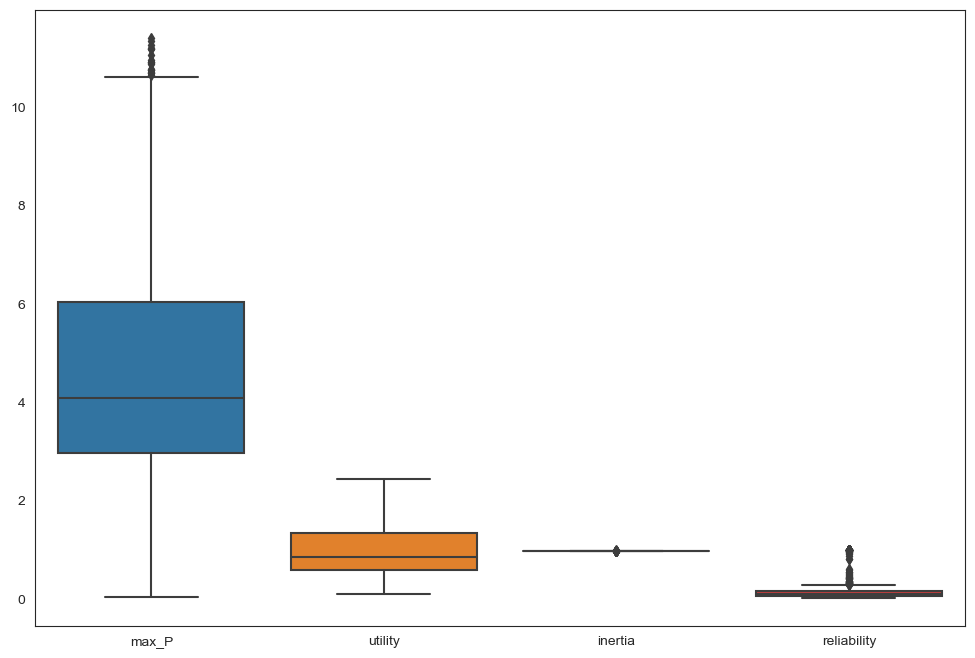

In [59]:
import seaborn as sns

sns.boxplot(pd.DataFrame.from_dict(outcomes))

# let's optimze the policies for a reference scenario

In [60]:
reference = Scenario("reference", b=0.4, q=2, mean=0.02, stdev=0.01)

In [61]:
from ema_workbench.em_framework.optimization import ArchiveLogger, EpsilonProgress

convergence_metrics = [
    ArchiveLogger(
        "./data",
        [l.name for l in lake_model.levers],
        [o.name for o in lake_model.outcomes],
        base_filename="lake_model_dps_archive.tar.gz",
    ),
    EpsilonProgress(),
]

with MultiprocessingEvaluator(lake_model) as evaluator:
    results, convergence = evaluator.optimize(
        searchover="levers",
        nfe=100000,
        epsilons=[0.05] * len(lake_model.outcomes),
        reference=reference,
        convergence=convergence_metrics,
    )

[MainProcess/INFO] pool started with 10 workers
100165it [09:16, 179.87it/s]                                                   
[MainProcess/INFO] optimization completed, found 46 solutions
[MainProcess/INFO] terminating pool


In [62]:
results.to_csv('./data/optimization_results.csv')

## analyze convergence

In [63]:

from ema_workbench import (
    HypervolumeMetric,
    GenerationalDistanceMetric,
    EpsilonIndicatorMetric,
    InvertedGenerationalDistanceMetric,
    SpacingMetric,
)
from ema_workbench.em_framework.optimization import to_problem

In [64]:
problem = to_problem(lake_model, searchover="levers")

hv = HypervolumeMetric(results, problem)
gd = GenerationalDistanceMetric(results, problem, d=1)
ei = EpsilonIndicatorMetric(results, problem)
ig = InvertedGenerationalDistanceMetric(results, problem, d=1)
sm = SpacingMetric(problem)

In [65]:
archives = ArchiveLogger.load_archives('./data/lake_model_dps_archive.tar.gz')

In [66]:
metrics = []
for key in sorted(archives.keys()):
    archive = archives[key]
    scores = {
        "generational_distance": gd.calculate(archive),
        "hypervolume": hv.calculate(archive),
        "epsilon_indicator": ei.calculate(archive),
        "inverted_gd": ig.calculate(archive),
        "spacing": sm.calculate(archive),
        "nfe": int(key),
    }
    metrics.append(scores)
metrics = pd.DataFrame.from_dict(metrics)


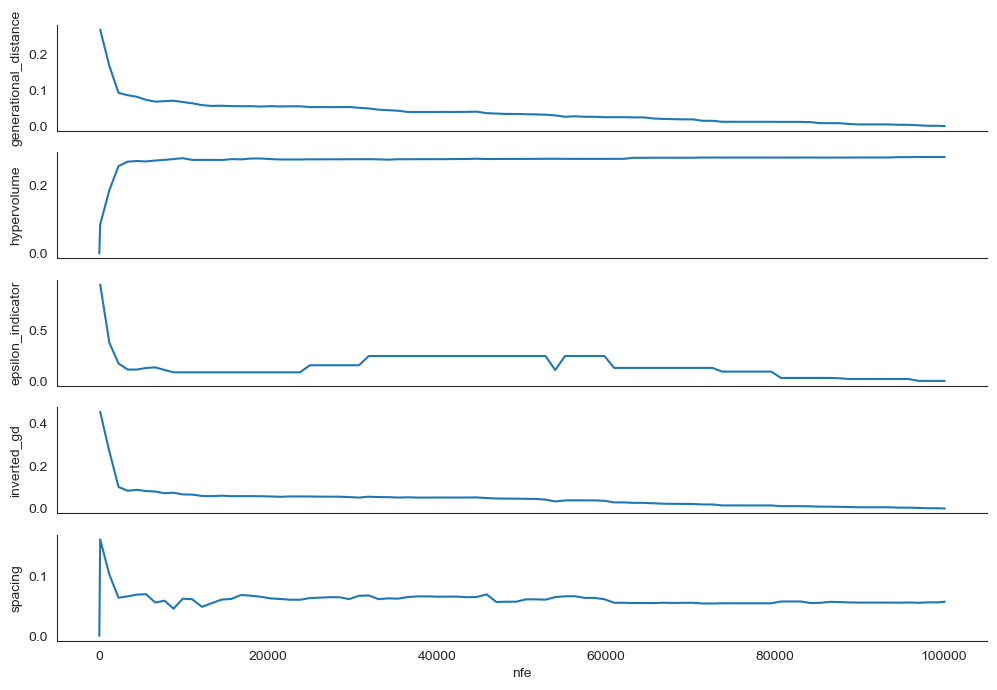

In [75]:
fig, axes = plt.subplots(nrows=5, sharex=True)

for i, entry in enumerate(["generational_distance", "hypervolume",
                        "epsilon_indicator", "inverted_gd", "spacing"]):
    ax = axes[i]
    ax.plot(metrics.loc[:, "nfe"], metrics.loc[:, entry])
    ax.set_ylabel(entry)
axes[-1].set_xlabel("nfe")
sns.despine()
plt.show()
    

# view results

In [105]:
from ema_workbench.analysis import parcoords

results = pd.read_csv('./data/optimization_results.csv', index_col=0)

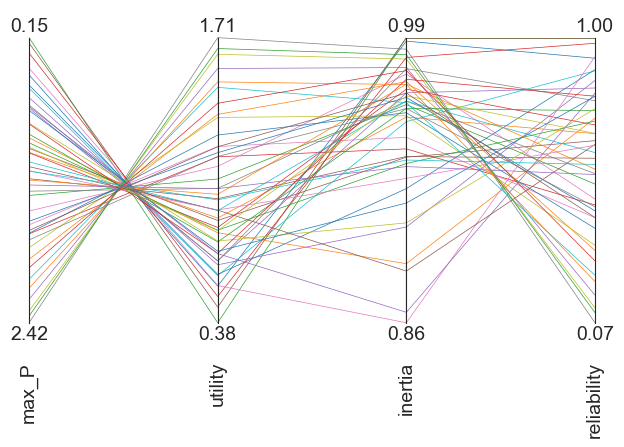

In [107]:
limits = parcoords.get_limits(results.iloc[:, 5::])
parplot = parcoords.ParallelAxes(limits)
parplot.plot(results.iloc[:, 5::], lw=0.5)
parplot.invert_axis("max_P")

fig = plt.gcf()
fig.set_size_inches(6, 4)

plt.show()

# reevaluate selected polices under deep uncertainty

In [108]:
maxima_results = results.iloc[:, 6::].idxmax().unique()
minima_results = results.iloc[:, 6::].idxmin().unique()

In [109]:
combined_indices = np.concatenate([minima_results, maxima_results])

In [110]:
unique_indices = np.unique(combined_indices)

In [111]:
results.iloc[unique_indices]

,c1,c2,r1,r2,w1,max_P,utility,inertia,reliability
2,0.240207,0.248977,0.251805,1.007877,0.314139,0.149642,0.381360,0.9900,1.0000
7,0.564291,0.169602,1.186980,0.065512,0.357578,2.423210,1.708293,0.9847,0.0736
26,0.623071,0.266867,1.460106,0.136209,0.064962,0.392313,0.554788,0.8593,0.9380


In [118]:
policies = []
for i, row in results.iloc[unique_indices, 0:5].iterrows():
    policy = Policy(f"{i}", **row.to_dict())
    policies.append(policy)

In [119]:
policies

[Policy({'c1': 0.240207075134193, 'c2': 0.2489767326875102, 'r1': 0.2518053853912461, 'r2': 1.0078767841632312, 'w1': 0.3141394423848772}),
 Policy({'c1': 0.5642909548608027, 'c2': 0.1696020262338388, 'r1': 1.1869798564925345, 'r2': 0.0655116887892095, 'w1': 0.3575782817887855}),
 Policy({'c1': 0.6230709417645058, 'c2': 0.2668669580914875, 'r1': 1.4601061857660984, 'r2': 0.1362093190840341, 'w1': 0.0649616415095989})]

In [120]:
with MultiprocessingEvaluator(lake_model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(1000, policies=policies)

[MainProcess/INFO] pool started with 10 workers
[MainProcess/INFO] performing 1000 scenarios * 3 policies * 1 model(s) = 3000 experiments
100%|█████████████████████████████████████| 3000/3000 [00:15<00:00, 192.74it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [123]:
save_results((experiments, outcomes), './data/reevaluted.tar.gz')

[MainProcess/INFO] results saved successfully to /Users/jhkwakkel/Documents/GitHub/dmdu_tutorial/src/data/reevaluted.tar.gz


In [127]:
data = pd.DataFrame.from_dict(outcomes)
data['policy'] = experiments.policy
data

,max_P,utility,inertia,reliability,policy
0,0.275765,0.185764,0.9900,1.0000,2
1,0.126670,0.560018,0.9900,1.0000,2
2,0.134387,0.266335,0.9900,1.0000,2
3,0.142034,0.254614,0.9900,1.0000,2
4,0.132242,0.220614,0.9900,1.0000,2
...,...,...,...,...,...
2995,0.249412,0.195785,0.9900,1.0000,26
2996,5.797071,1.081212,0.9776,0.0323,26
2997,0.229252,0.418141,0.6862,1.0000,26
2998,0.240350,0.415830,0.5918,1.0000,26


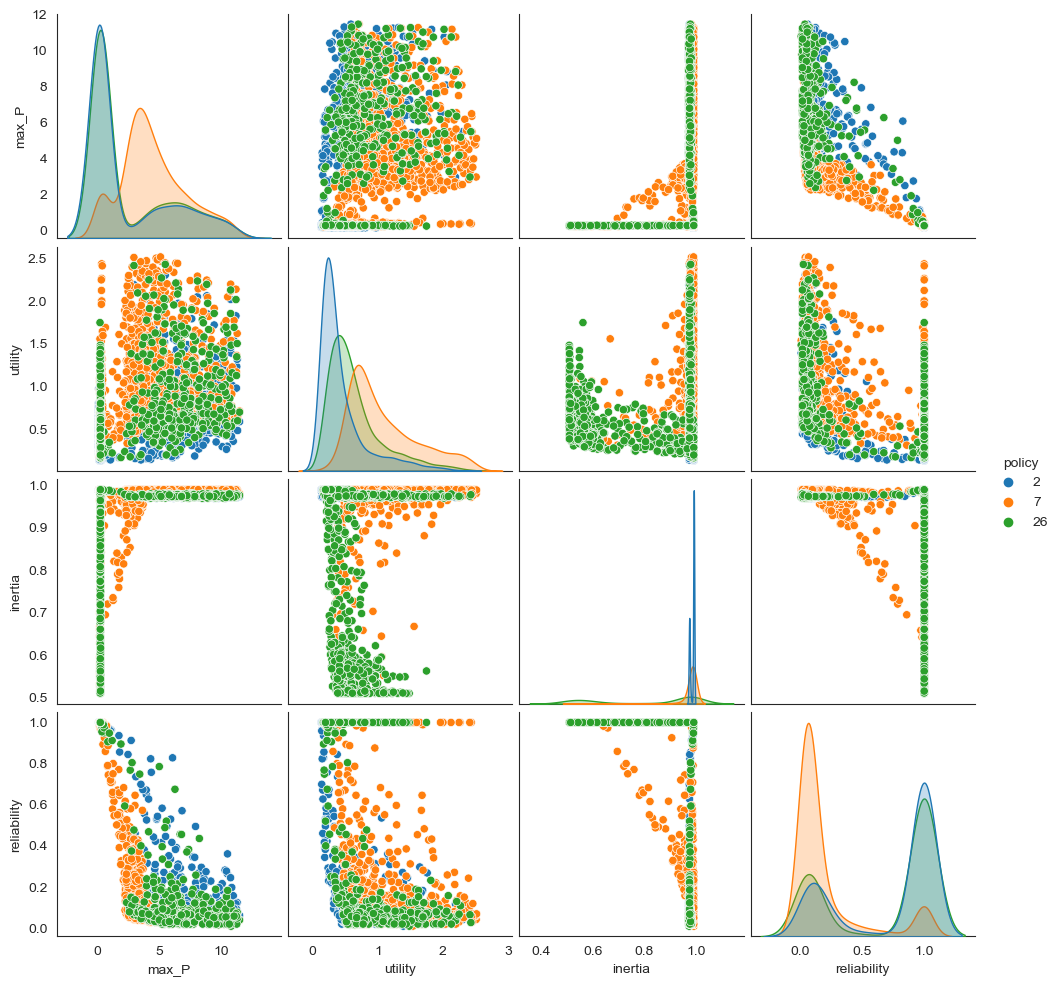

In [130]:
sns.pairplot(data, hue='policy')
plt.show()

In [197]:
# calculate robustness

In [213]:
experiments.head()

,b,delta,mean,q,stdev,c1,c2,r1,r2,w1,scenario,policy,model
0,0.155413,0.963832,0.027344,4.043808,0.001799,0.240207,0.248977,0.251805,1.007877,0.314139,4000,2,lakeproblem
1,0.430083,0.978440,0.023274,4.039722,0.002261,0.240207,0.248977,0.251805,1.007877,0.314139,4001,2,lakeproblem
2,0.321205,0.948938,0.015925,4.472107,0.004238,0.240207,0.248977,0.251805,1.007877,0.314139,4002,2,lakeproblem
3,0.390695,0.959145,0.035153,4.001970,0.002208,0.240207,0.248977,0.251805,1.007877,0.314139,4003,2,lakeproblem
4,0.429144,0.933755,0.024798,2.680790,0.004577,0.240207,0.248977,0.251805,1.007877,0.314139,4004,2,lakeproblem


In [214]:
data = pd.DataFrame.from_dict(outcomes)
data['scenario'] = experiments.scenario.astype(int)

In [215]:
data.groupby('scenario').max()

,max_P,utility,inertia,reliability
scenario,,,,
4000,7.252232,1.078159,0.9900,1.0000
4001,0.306584,1.528350,0.9900,1.0000
4002,0.434885,0.643840,0.9900,1.0000
4003,0.429983,0.955420,0.9900,1.0000
4004,2.423825,0.573158,0.9900,1.0000
...,...,...,...,...
4995,3.514007,0.830908,0.9900,1.0000
4996,5.797252,1.131718,0.9849,0.0572
4997,3.960674,1.097429,0.9900,1.0000


In [216]:
def calculate_best_performance(df):
    data = {}
    
    for outcome in lake_model.outcomes:
        if outcome.kind == ScalarOutcome.MAXIMIZE:
            data[outcome.name] = df[outcome.name].max()
        else:
            data[outcome.name] = df[outcome.name].min()
    
    return pd.Series(data)

In [217]:
best_performance = data.groupby('scenario').apply(calculate_best_performance)

In [218]:
best_performance

,max_P,utility,inertia,reliability
scenario,,,,
4000,0.275765,1.078159,0.9900,1.0000
4001,0.126670,1.528350,0.9900,1.0000
4002,0.134387,0.643840,0.9900,1.0000
4003,0.142034,0.955420,0.9900,1.0000
4004,0.132242,0.573158,0.9900,1.0000
...,...,...,...,...
4995,0.227272,0.830908,0.9900,1.0000
4996,5.796942,1.131718,0.9849,0.0572
4997,0.156669,1.097429,0.9900,1.0000


In [219]:
def calculate_regret(df):
    df = df.set_index('scenario')
    df.drop('policy', axis=1, inplace=True)
    return best_performance - df

In [220]:
data['policy'] = experiments.policy

In [221]:
regret = data.groupby('policy').apply(calculate_regret)

In [222]:
max_regret = regret.groupby(level=0).apply(calculate_best_performance)
max_regret

,max_P,utility,inertia,reliability
policy,,,,
2,-0.002841,2.188907,0.0200,0.0009
26,-7.916725,2.151758,0.4800,0.9174
7,-9.627019,0.497873,0.4619,0.9561
